# Perform TF analysis to identify clusters that may be targetted by TFs

In [67]:

import pandas as pd
import numpy as np

base_dir = '../data/'
data_dir = f'{base_dir}sircle/F3_regulatory_clustering/'
output_dir = f'{base_dir}sircle/F4_TF_analysis/'
fig_dir = '../figures/'
supp_dir = f'{base_dir}raw_downloads/supps/'
gene_name = 'hgnc_symbol'
save_fig = False
test_title = 'all_patients_ccRCC'
run_label = 'P0.5-R1.0-M0.1'

In [68]:
tf_file = supp_dir + 'dorothea_hs_ABCD.csv'
mo = SciMotf_Doro(doro_file=tf_file, cluster_file=rcm_file, cluster_gene_id='external_gene_name', # got to match motif
                 padj_protein='padj_protein', logfc_protein='logFC_protein', padj_rna='padj_rna',
                  logfc_rna='logFC_rna', output_dir=output_dir)

df = mo.run(['A'], rcm_clusters=["MDS", "MDS_TMDE", "MDE", "MDE_TMDS", "TPDE", "TPDE_TMDS", "TPDS", "TPDS_TMDE",])
df.to_csv(f'{output_dir}scimotif_DORO_A.csv')

     Unnamed: 0  tf confidence  target  mor
480         481  AR          A   ABCE1    1
481         482  AR          A  ACAD10    1
482         483  AR          A    ACP3    1
483         484  AR          A    AHSG    1
484         485  AR          A  AKR1B1    1
--------------------------------------------------------------------------------
WARN: no background ID set, using all genes in the supplied DF as the background.
Number of genes: 	5602	
--------------------------------------------------------------------------------


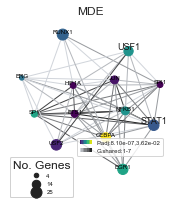

<Figure size 216x216 with 0 Axes>

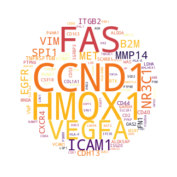

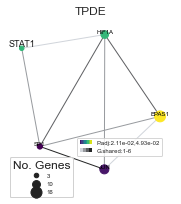

<Figure size 216x216 with 0 Axes>

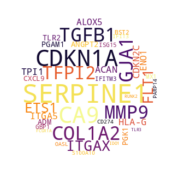

In [69]:
plot_cluster_tf(f'{output_dir}scimotif_DORO_A.csv')

## Format the ChIP peaks from ChIP atlas

In [70]:
# Read the bed files and save the 3 separate files for HIF1A
# 1) RCC kidney 2) other kidney, 3) all other tissues
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE120887 good study 
chip_dir = f'{base_dir}/raw_downloads/ChIP_atlas/'
with open(f'{chip_dir}Oth.ALL.05.HIF1A.AllCell.bed', 'r') as f:
    with open(f'files/HIF1A_kidney_RCC.bed', 'w+') as rcc:
        with open(f'files/HIF1A_kidney_other.bed', 'w+') as kidney:
            with open(f'files/HIF1A_OTHER.bed', 'w+') as all_other:
                first = True
                for line in f:
                    line = line.replace('%20', '').replace('@', '')
                    if first:
                        rcc.write(line)
                        kidney.write(line)
                        all_other.write(line)
                        first = False
                    else:
                        if 'Title=GSM2723878' in line or ('RCC' in line and 'Title' in line):
                            rcc.write(line)
                        elif 'group=Kidney' in line:
                            kidney.write(line)
                        else:
                            all_other.write(line)

In [71]:
# Read the bed files and save the 3 separate files for HIF1A
# 1) RCC kidney 2) other kidney, 3) all other tissues
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE120887 good study 
with open(f'{chip_dir}Oth.ALL.05.EPAS1.AllCell.bed', 'r') as f:
    with open(f'files/HIF1B-EPAS1_kidney_RCC.bed', 'w+') as rcc:
        with open(f'files/HIF1B-EPAS1_kidney_other.bed', 'w+') as kidney:
            with open(f'files/HIF1B-EPAS1_OTHER.bed', 'w+') as all_other:
                first = True
                for line in f:
                    line = line.replace('%20', '').replace('@', '')
                    if first:
                        rcc.write(line)
                        kidney.write(line)
                        all_other.write(line)
                        first = False
                    else:
                        if 'Title=GSM1642766' in line or ('RCC' in line and 'Title' in line):
                            rcc.write(line)
                        elif 'group=Kidney' in line:
                            kidney.write(line)
                        else:
                            all_other.write(line)

## Use IGV to view genes

In [72]:
import igv

b = igv.Browser({"genome": "hg38"})
b.show()

# Load HIF1A and HIF1B/EPAS1
b.load_track(
    {
        "name": "HIF1A RCC",
        "url": 'files/HIF1A_kidney_RCC.bed',
        "format": "bed",
        "type": "annotation",
        "sourceType": "file",
        "indexed": False,
        "displayMode": "EXPANDED",
        "color": "#b91c1c" #"#e58f35" # same colour as TPDE
    })

b.load_track(
    {
        "name": "EPAS1 RCC",
        "url": 'files/HIF1B-EPAS1_kidney_RCC.bed',
        "format": "bed",
        "type": "annotation",
        "sourceType": "file",
        "indexed": False,
        "displayMode": "EXPANDED",
        "color": "#93c5fd" #"#e58f35" # same colour as TPDE
    })
